In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikits.bootstrap as boot
from os import path, makedirs
from matplotlib.ticker import ScalarFormatter, MaxNLocator

from brainpipe.system import study
from brainpipe.visual import *
from brainpipe.statistics import *
from mne.baseline import rescale
from mne.filter import filter_data, resample
from scipy.stats import *
import glob

In [5]:
# ANALYSIS PARAMETERS
low_pass_filter = 10.
sf = 512.
norm_mode = 'mean' #'ratio' 'mean' 'percent' 
bsl = (1485,1536) #(922,1024) #-200 to 0ms before odor perception
data_to_use = [1485, 1895] #-200 to 2000ms after odor
time_points = data_to_use[1]-data_to_use[0]
n_rep = 100 #bootstrap
alpha = 0.05
resamp = 5.12

In [49]:
st = study('Olfacto')

exp, pval, freq = 'Encoding', '0.01', 'theta'
conds = ['low','high']

data_path = path.join(st.path, 'database/{}_EpiPerf_LowHigh/')
dataname = path.join(data_path, '{}_odor_{}_common_renamed_OFC_HC.npz')

df_path = path.join(st.path, 'figure/TPSim_LDA_{}_by_cond_6freqs_3s_dissim/')
savename = path.join(df_path, 'ERPs_{}/ERP_{}_{}_elec({})_boot'+str(n_rep)+'_3s.png')
savename2 = path.join(df_path, 'ERPs_{}/ERP_{}_{}_elec({})_boot'+str(n_rep)+'_3s.pdf')

if not path.exists(df_path.format(exp[0])+'ERPs_{}'.format(pval)):
    makedirs(df_path.format(exp[0])+'ERPs_{}'.format(pval))
    
files = glob.glob(df_path.format(exp[0])+'npy_figs/'+freq+'*'+pval+'_tps.csv')

for fi in files:
    lab = fi.split('_')[-4]
    df = pd.read_csv(fi)
    subjects, channels = df['subjects'], df['channels']

    for su,chan in zip(subjects, channels):
        mat0 = np.load(dataname.format(exp,su,conds[0]),allow_pickle=True)
        mat1 = np.load(dataname.format(exp,su,conds[1]),allow_pickle=True)
        # 3584 points >> 7s from -3 to +4s
        data0, data1 = mat0['x'], mat1['x']
        labels, mat_chans = mat0['labels'], mat0['channels']
        idx = [i for i,c in enumerate(mat_chans) if c==chan][0]

        x0, x1 = data0[idx].swapaxes(0,1), data1[idx].swapaxes(0,1)

        time = np.arange(x0.shape[1])
        norm_x0 = rescale(x0, times=time, baseline=bsl, mode=norm_mode)
        norm_x1 = rescale(x1, times=time, baseline=bsl, mode=norm_mode)
        print(norm_x0.shape, norm_x1.shape)

        data0_rep, data1_rep = np.array([]), np.array([])
        for i in range(n_rep):
            if norm_x0.shape[0] > norm_x1.shape[0]:
                data0_sel = np.mean(norm_x0[np.random.randint(norm_x0.shape[0],
                                            size=norm_x1.shape[0]), :], axis=0)
                data1_sel = norm_x1
            if norm_x0.shape[0] < norm_x1.shape[0]:
                data0_sel = norm_x0
                data1_sel = np.mean(norm_x1[np.random.randint(norm_x1.shape[0], 
                                            size=norm_x0.shape[0]), :], axis=0)
            elif norm_x0.shape[0] == norm_x1.shape[0]:
                data0_sel, data1_sel = norm_x0, norm_x1
            data0_rep = np.vstack((data0_rep, data0_sel)) if np.size(data0_rep) else data0_sel
            data1_rep = np.vstack((data1_rep, data1_sel)) if np.size(data1_rep) else data1_sel
        print('data bad, good',data0_rep.shape, data1_rep.shape)

        mean_x0, mean_x1 = np.mean(data0_rep,axis=0),np.mean(data1_rep,axis=0)
        print(mean_x0.shape, mean_x1.shape)
        mean_x0, mean_x1 = np.array(mean_x0, dtype='float64'), np.array(mean_x1, dtype='float64')

        filt_x0 = filter_data(mean_x0, sfreq=sf, l_freq=None, h_freq=low_pass_filter, 
                                                  method='fir', phase='zero-double')
        filt_x1 = filter_data(mean_x1, sfreq=sf, l_freq=None, h_freq=low_pass_filter, 
                                                  method='fir', phase='zero-double')
        final_x0 = filt_x0[data_to_use[0]:data_to_use[1]][np.newaxis]
        final_x1 = filt_x1[data_to_use[0]:data_to_use[1]][np.newaxis]
        final_x0, final_x1 = resample(final_x0,down=resamp), resample(final_x1,down=resamp)
        print(su, lab, 'low norm shape', final_x0.shape, 'high norm shape', 
              final_x1.shape)

        # ========================== PREPARE PLOTS AND SAVE STATS =========================================
        # plot and figure parameters
        xfmt = ScalarFormatter(useMathText=True)
        xfmt.set_powerlimits((0,3))
        fig = plt.figure(1,figsize=(9,6))
        title = 'ERP and Stats for {} High/Low in {}'.format(su,lab)
        fig.suptitle(title, fontsize=12)
        times_plot = np.arange(-100,1000,10)
        print('time plots', times_plot.shape)
        # Plot the ERPs and the stats
        data_all = np.concatenate((final_x0, final_x1), axis=0)
        y = np.array([0]+[1])
        data_plot = norm_x1[:,data_to_use[0]:data_to_use[1]].swapaxes(0,1)
        #plt.plot(times_plot, data_plot)
        BorderPlot(times_plot, data_all, y=y, kind='sd', alpha=0.2, color=['cornflowerblue','b'], 
                   linewidth=2, ncol=1, xlabel='Time (ms)',ylabel = r' $\mu$V', 
                   legend = ['Low', 'High'])
        addLines(plt.gca(), vLines=[0], vColor=['r'], vWidth=[2], hLines=[0], 
                 hColor=['#000000'], hWidth=[2])
        rmaxis(plt.gca(), ['right', 'top'])
        plt.legend(loc=0, handletextpad=0.1, frameon=False)
        plt.gca().yaxis.set_major_locator(MaxNLocator(3,integer=True))
        plt.savefig(savename.format(exp[0],pval,su,lab,chan), dpi=300, bbox_inches='tight')
        plt.savefig(savename2.format(exp[0],pval,su,lab,chan), dpi=300, bbox_inches='tight')
        plt.clf()
        plt.close()
        

-> Olfacto loaded
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
(34, 3584) (21, 3584)
data bad, good (100, 3584) (2100, 3584)
(3584,) (3584,)
Setting up low-pass filter at 10 Hz
h_trans_bandwidth chosen to be 2.5 Hz
Filter length of 677 samples (1.322 sec) selected
Setting up low-pass filter at 10 Hz
h_trans_bandwidth chosen to be 2.5 Hz
Filter length of 677 samples (1.322 sec) selected
LEFC olf low norm shape (1, 110) high norm shape (1, 110)
time plots (110,)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
(14, 3584) (11, 3584)
data bad, good (100, 3584) (1100, 3584)
(3584,) (3584,)
Setting up low-pass filter at 10 Hz
h_trans_bandwidth chosen to be 2.5 Hz
Filter length of 677 samples (1.322 sec) selected
Setting up low-pass filter at 10 Hz
h_trans_bandwidth chosen to be 2.5 Hz
Filter length of 677 samples (1.322 sec) selected
PIRJ olf low norm shape (1, 110) high norm shape (1, 110)
time plots (110,)


In [56]:
"""
Plot ERP combining Rich and Poor together
"""
st = study('Olfacto')

exp, pval, freq = 'Retrieval', '0.01', 'theta'
conds = ['low','high']

data_path = path.join(st.path, 'database/{}_EpiPerf_LowHigh/')
dataname = path.join(data_path, '{}_odor_{}_common_renamed_OFC_HC.npz')

df_path = path.join(st.path, 'figure/TPSim_LDA_{}_by_cond_6freqs_3s_dissim/')
savename = path.join(df_path, 'ERPs_{}/ERP_{}_{}_elec({})_all_3s.png')
savename2 = path.join(df_path, 'ERPs_{}/ERP_{}_{}_elec({})_all_3s.pdf')

if not path.exists(df_path.format(exp[0])+'ERPs_{}'.format(pval)):
    makedirs(df_path.format(exp[0])+'ERPs_{}'.format(pval))
    
files = glob.glob(df_path.format(exp[0])+'npy_figs/'+freq+'*'+pval+'_tps.csv')

for fi in files:
    lab = fi.split('_')[-4]
    df = pd.read_csv(fi)
    subjects, channels = df['subjects'], df['channels']

    for su,chan in zip(subjects, channels):
        mat0 = np.load(dataname.format(exp,su,conds[0]),allow_pickle=True)
        mat1 = np.load(dataname.format(exp,su,conds[1]),allow_pickle=True)
        # 3584 points >> 7s from -3 to +4s
        data0, data1 = mat0['x'], mat1['x']
        data = np.concatenate((data0,data1), axis=-1)
        labels, mat_chans = mat0['labels'], mat0['channels']
        idx = [i for i,c in enumerate(mat_chans) if c==chan][0]

        X = data[idx].swapaxes(0,1)
        time = np.arange(X.shape[1])
        norm_x0 = rescale(X, times=time, baseline=bsl, mode=norm_mode)
        mean_x0 = np.mean(norm_x0,axis=0)
        mean_x0 = np.array(mean_x0, dtype='float64')

        filt_x0 = filter_data(mean_x0, sfreq=sf, l_freq=None, h_freq=low_pass_filter, 
                                                  method='fir', phase='zero-double')
        final_x0 = filt_x0[data_to_use[0]:data_to_use[1]][np.newaxis]
        final_x0 = resample(final_x0,down=resamp)
        print(su, lab, 'All data norm shape', final_x0.shape)

        # ========================== PREPARE PLOTS AND SAVE STATS =========================================
        # plot and figure parameters
        xfmt = ScalarFormatter(useMathText=True)
        xfmt.set_powerlimits((0,3))
        fig = plt.figure(1,figsize=(9,6))
        title = 'ERP and Stats for {} High/Low in {}'.format(su,lab)
        fig.suptitle(title, fontsize=12)
        times_plot = np.arange(-100,1000,10)
        print('time plots', times_plot.shape)
        # Plot the ERPs and the stats
        BorderPlot(times_plot, final_x0, y=None, kind='sd', alpha=0.2, color=['black'], 
                   linewidth=2, ncol=1, xlabel='Time (ms)',ylabel = r' $\mu$V')
        addLines(plt.gca(), vLines=[0], vColor=['r'], vWidth=[2], hLines=[0], 
                 hColor=['#000000'], hWidth=[2])
        rmaxis(plt.gca(), ['right', 'top'])
        plt.gca().yaxis.set_major_locator(MaxNLocator(3,integer=True))
        plt.savefig(savename.format(exp[0],pval,su,lab,chan), dpi=300, bbox_inches='tight')
        plt.savefig(savename2.format(exp[0],pval,su,lab,chan), dpi=300, bbox_inches='tight')
        plt.clf()
        plt.close()
        

-> Olfacto loaded
Applying baseline correction (mode: mean)
Setting up low-pass filter at 10 Hz
h_trans_bandwidth chosen to be 2.5 Hz
Filter length of 677 samples (1.322 sec) selected
FERJ IFG All data norm shape (1, 110)
time plots (110,)
Applying baseline correction (mode: mean)
Setting up low-pass filter at 10 Hz
h_trans_bandwidth chosen to be 2.5 Hz
Filter length of 677 samples (1.322 sec) selected
PIRJ IFG All data norm shape (1, 110)
time plots (110,)
Applying baseline correction (mode: mean)
Setting up low-pass filter at 10 Hz
h_trans_bandwidth chosen to be 2.5 Hz
Filter length of 677 samples (1.322 sec) selected
PIRJ IFG All data norm shape (1, 110)
time plots (110,)
Applying baseline correction (mode: mean)
Setting up low-pass filter at 10 Hz
h_trans_bandwidth chosen to be 2.5 Hz
Filter length of 677 samples (1.322 sec) selected
SEMC IFG All data norm shape (1, 110)
time plots (110,)
Applying baseline correction (mode: mean)
Setting up low-pass filter at 10 Hz
h_trans_bandwidt

In [12]:
"""
Plot ERPs and F-test between conditions
Average and filter ERPs just for visualization (after stats)
"""
%matplotlib inline
import matplotlib.pyplot as plt

import mne
from mne import io
from mne.baseline import rescale
from mne.filter import filter_data
from mne.stats import permutation_cluster_test

import numpy as np
import pandas as pd
from brainpipe.system import study
from os import path, makedirs
import glob

In [42]:
low_pass_filter = 10.
sf = 512.
norm_mode = 'mean' #'ratio' 'mean' 'percent' 
bsl = (1485,1536) #-200 to 0ms before odor perception
data_to_use = [1485, 2048] #-200 to 2000ms after odor
time_points = data_to_use[1]-data_to_use[0]
n_permutations = 1000

-> Olfacto loaded
(34, 3584) (21, 3584)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
(34, 563) (21, 563)
Using a threshold of 4.023017
stat_fun(H1): min=0.000175 max=6.870533
Running initial clustering
Found 4 clusters
Permuting 999 times...
[........                                          ]  16.42%  |   

<ipython-input-44-51d4b7779a0a>:52: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  n_permutations=n_permutations,n_jobs=1)


[..................................................] 100.00%  |   
Computing cluster p-values
Done.
0.577
0.343
0.271
0.7
(14, 3584) (11, 3584)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
(14, 563) (11, 563)
Using a threshold of 4.279344
stat_fun(H1): min=0.004433 max=7.658583
Running initial clustering
Found 4 clusters
Permuting 999 times...
[.....                                             ]  11.81%  |   

<ipython-input-44-51d4b7779a0a>:52: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  n_permutations=n_permutations,n_jobs=1)


[..................................................] 100.00%  |   
Computing cluster p-values
Done.
0.825
0.61
0.706
0.704


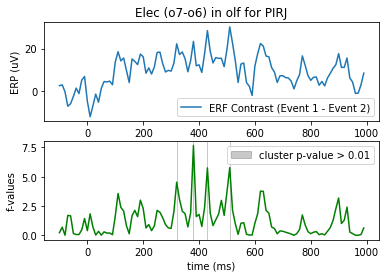

In [44]:
st = study('Olfacto')

exp, pval, freq = 'Encoding', '0.01', 'theta'
conds = ['low','high']

data_path = path.join(st.path, 'database/{}_EpiPerf_LowHigh/')
dataname = path.join(data_path, '{}_odor_{}_common_renamed_OFC_HC.npz')

df_path = path.join(st.path, 'figure/TPSim_LDA_{}_by_cond_6freqs_3s_dissim/')
savename = path.join(df_path, 'ERPs_{}/ERP_{}_{}_elec({})_stats_1s.png')
savename2 = path.join(df_path, 'ERPs_{}/ERP_{}_{}_elec({})_stats_1s.pdf')

if not path.exists(df_path.format(exp[0])+'ERPs_{}'.format(pval)):
    makedirs(df_path.format(exp[0])+'ERPs_{}'.format(pval))
    
files = glob.glob(df_path.format(exp[0])+'npy_figs/'+freq+'*'+pval+'_tps.csv')

for fi in files:
    lab = fi.split('_')[-4]
    if lab == 'olf':
        df = pd.read_csv(fi)
        subjects, channels = df['subjects'], df['channels']

        for su,chan in zip(subjects, channels):
            mat0 = np.load(dataname.format(exp,su,conds[0]),allow_pickle=True)
            mat1 = np.load(dataname.format(exp,su,conds[1]),allow_pickle=True)
            # 3584 points >> 7s from -3 to +4s
            data0, data1 = mat0['x'], mat1['x']
            labels, mat_chans = mat0['labels'], mat0['channels']
            idx = [i for i,c in enumerate(mat_chans) if c==chan][0]

            x0, x1 = data0[idx].swapaxes(0,1), data1[idx].swapaxes(0,1)
            print(x0.shape, x1.shape)

            time = np.arange(x0.shape[1])
            norm_x0 = rescale(x0, times=time, baseline=bsl, mode=norm_mode)
            norm_x1 = rescale(x1, times=time, baseline=bsl, mode=norm_mode)
            #norm_x0 = np.array(norm_x0, dtype='float64')
            #norm_x1 = np.array(norm_x1, dtype='float64')

            #filt_x0 = filter_data(norm_x0, sfreq=512, l_freq=None, h_freq=low_pass_filter, 
            #                                          method='fir', phase='zero-double')
            #filt_x1 = filter_data(norm_x1, sfreq=512, l_freq=None, h_freq=low_pass_filter, 
            #                                          method='fir', phase='zero-double')

            data_x0 = norm_x0[:,data_to_use[0]:data_to_use[1]]
            data_x1 = norm_x1[:,data_to_use[0]:data_to_use[1]]
            print(data_x0.shape, data_x1.shape)
            data_x0, data_x1 = resample(data_x0,down=resamp), resample(data_x1,down=resamp)

            T_obs, clusters, cluster_p_values, H0 = \
                permutation_cluster_test([data_x0, data_x1], 
                                         n_permutations=n_permutations,n_jobs=1)


            time_plot = np.arange(-100,1000,10)
            #time_plot = 1000 * np.arange(0, data_to_use[1]-bsl[1]) / sf
            plt.close('all')
            plt.subplot(211)
            plt.title('Elec ({}) in {} for {}'.format(chan,lab,su))
            plt.plot(time_plot, data_x0.mean(axis=0) - data_x1.mean(axis=0),
                     label="ERF Contrast (Event 1 - Event 2)")
            plt.ylabel("ERP (uV)")
            plt.legend()
            plt.subplot(212)
            for i_c, c in enumerate(clusters):
                c = c[0]
                print(cluster_p_values[i_c])
                if cluster_p_values[i_c] <= (0.01):
                    h = plt.axvspan(time_plot[c.start], time_plot[c.stop - 1],
                                    color='r', alpha=0.3)
                    plt.legend((h, ), ('cluster p-value < 0.01', ))

                else:
                    h = plt.axvspan(time_plot[c.start], time_plot[c.stop - 1], color=(0.3, 0.3, 0.3),
                                alpha=0.3)
                    plt.legend((h, ), ('cluster p-value > 0.01', ))

            hf = plt.plot(time_plot, T_obs, 'g')
            plt.xlabel("time (ms)")
            plt.ylabel("f-values")
            plt.savefig(savename.format(exp[0],pval,su,lab,chan), dpi=300, bbox_inches='tight')
            plt.savefig(savename2.format(exp[0],pval,su,lab,chan), dpi=300, bbox_inches='tight')


In [57]:
"""
Plot ERPs and F-test VS BASELINE 
Average and filter ERPs just for visualization (after stats)
"""
%matplotlib inline
import matplotlib.pyplot as plt

import mne
from mne import io
from mne.baseline import rescale
from mne.filter import filter_data
from mne.stats import permutation_cluster_test

import numpy as np
import pandas as pd
from brainpipe.system import study
from os import path, makedirs
import glob

In [58]:
low_pass_filter = 10.
sf = 512.
norm_mode = 'mean' #'ratio' 'mean' 'percent' 
bsl = (1485,1536) #-200 to 0ms before odor perception
data_to_use = [1485, 2048] #-200 to 2000ms after odor
time_points = data_to_use[1]-data_to_use[0]
n_permutations = 1000

-> Olfacto loaded
Applying baseline correction (mode: mean)
Using a threshold of 4.051749
stat_fun(H1): min=0.001687 max=9.954097
Running initial clustering
Found 3 clusters
Permuting 999 times...
[.........                                         ]  18.12%  |   

<ipython-input-60-fa7ebda32238>:42: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  n_permutations=n_permutations,n_jobs=1)


[..................................................] 100.00%  |   
Computing cluster p-values
Done.
0.509
0.062
0.314
Applying baseline correction (mode: mean)
Using a threshold of 3.995887
stat_fun(H1): min=0.003462 max=8.869246
Running initial clustering
Found 4 clusters
Permuting 999 times...
[.....                                             ]  11.91%  |   

<ipython-input-60-fa7ebda32238>:42: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  n_permutations=n_permutations,n_jobs=1)


[..................................................] 100.00%  |   
Computing cluster p-values
Done.
0.302
0.691
0.064
0.252
Applying baseline correction (mode: mean)
Using a threshold of 3.995887
stat_fun(H1): min=0.000034 max=19.642498
Running initial clustering
Found 7 clusters
Permuting 999 times...
[.......                                           ]  14.11%  |   

<ipython-input-60-fa7ebda32238>:42: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  n_permutations=n_permutations,n_jobs=1)


[..................................................] 100.00%  |   
Computing cluster p-values
Done.
0.047
0.007
0.065
0.109
0.277
0.654
0.427
Applying baseline correction (mode: mean)
Using a threshold of 4.051749
stat_fun(H1): min=0.000258 max=3.106190
Running initial clustering
Found 0 clusters


<ipython-input-60-fa7ebda32238>:42: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  n_permutations=n_permutations,n_jobs=1)
<ipython-input-60-fa7ebda32238>:42: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  n_permutations=n_permutations,n_jobs=1)


Applying baseline correction (mode: mean)
Using a threshold of 4.051749
stat_fun(H1): min=0.002850 max=5.430829
Running initial clustering
Found 3 clusters
Permuting 999 times...
[........                                          ]  17.32%  |   

<ipython-input-60-fa7ebda32238>:42: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  n_permutations=n_permutations,n_jobs=1)


[..................................................] 100.00%  |   
Computing cluster p-values
Done.
0.661
0.709
0.54
Applying baseline correction (mode: mean)
Using a threshold of 4.051749
stat_fun(H1): min=0.000005 max=11.756524
Running initial clustering
Found 7 clusters
Permuting 999 times...
[.......                                           ]  15.12%  |   

<ipython-input-60-fa7ebda32238>:42: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  n_permutations=n_permutations,n_jobs=1)


[..................................................] 100.00%  |   
Computing cluster p-values
Done.
0.31
0.12
0.091
0.116
0.276
0.057
0.146
Applying baseline correction (mode: mean)
Using a threshold of 4.051749
stat_fun(H1): min=0.000047 max=6.300354
Running initial clustering
Found 2 clusters
Permuting 999 times...
[......                                            ]  12.91%  |   

<ipython-input-60-fa7ebda32238>:42: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  n_permutations=n_permutations,n_jobs=1)


[..................................................] 100.00%  |   
Computing cluster p-values
Done.
0.332
0.301
Applying baseline correction (mode: mean)
Using a threshold of 4.051749
stat_fun(H1): min=0.000155 max=11.425746
Running initial clustering
Found 1 clusters
Permuting 999 times...
[........                                          ]  17.02%  |   

<ipython-input-60-fa7ebda32238>:42: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  n_permutations=n_permutations,n_jobs=1)


[..................................................] 100.00%  |   
Computing cluster p-values
Done.
0.008
Applying baseline correction (mode: mean)
Using a threshold of 4.051749
stat_fun(H1): min=0.000074 max=6.863761
Running initial clustering
Found 2 clusters
Permuting 999 times...
[                                                  ]   1.40%  |   

<ipython-input-60-fa7ebda32238>:42: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  n_permutations=n_permutations,n_jobs=1)


[..................................................] 100.00%  |   
Computing cluster p-values
Done.
0.483
0.354
Applying baseline correction (mode: mean)
Using a threshold of 4.051749
stat_fun(H1): min=0.000097 max=5.798962
Running initial clustering
Found 1 clusters
Permuting 999 times...
[.......                                           ]  15.82%  |   

<ipython-input-60-fa7ebda32238>:42: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  n_permutations=n_permutations,n_jobs=1)


[..................................................] 100.00%  |   
Computing cluster p-values
Done.
0.384
Applying baseline correction (mode: mean)
Using a threshold of 4.051749
stat_fun(H1): min=0.000386 max=4.262722
Running initial clustering
Found 1 clusters
Permuting 999 times...
[........                                          ]  16.52%  |   

<ipython-input-60-fa7ebda32238>:42: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  n_permutations=n_permutations,n_jobs=1)


[..................................................] 100.00%  |   
Computing cluster p-values
Done.
0.601
Applying baseline correction (mode: mean)
Using a threshold of 4.051749
stat_fun(H1): min=0.000039 max=16.221657
Running initial clustering
Found 4 clusters
Permuting 999 times...
[......                                            ]  13.81%  |   

<ipython-input-60-fa7ebda32238>:42: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  n_permutations=n_permutations,n_jobs=1)


[..................................................] 100.00%  |   
Computing cluster p-values
Done.
0.006
0.626
0.556
0.305
Applying baseline correction (mode: mean)
Using a threshold of 4.051749
stat_fun(H1): min=0.000024 max=3.154004
Running initial clustering
Found 0 clusters


<ipython-input-60-fa7ebda32238>:42: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  n_permutations=n_permutations,n_jobs=1)
<ipython-input-60-fa7ebda32238>:42: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  n_permutations=n_permutations,n_jobs=1)


Applying baseline correction (mode: mean)
Using a threshold of 4.051749
stat_fun(H1): min=0.001539 max=8.021932
Running initial clustering
Found 1 clusters
Permuting 999 times...
[........                                          ]  16.72%  |   

<ipython-input-60-fa7ebda32238>:42: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  n_permutations=n_permutations,n_jobs=1)


[..................................................] 100.00%  |   
Computing cluster p-values
Done.
0.432


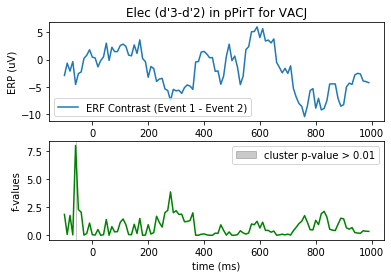

In [60]:
st = study('Olfacto')

exp, pval, freq = 'Retrieval', '0.01', 'theta'
conds = ['low','high']

data_path = path.join(st.path, 'database/{}_EpiPerf_LowHigh/')
dataname = path.join(data_path, '{}_odor_{}_common_renamed_OFC_HC.npz')

df_path = path.join(st.path, 'figure/TPSim_LDA_{}_by_cond_6freqs_3s_dissim/')
savename = path.join(df_path, 'ERPs_{}/ERP_{}_{}_elec({})_all_stats_1s.png')
savename2 = path.join(df_path, 'ERPs_{}/ERP_{}_{}_elec({})_all_stats_1s.pdf')

if not path.exists(df_path.format(exp[0])+'ERPs_{}'.format(pval)):
    makedirs(df_path.format(exp[0])+'ERPs_{}'.format(pval))
    
files = glob.glob(df_path.format(exp[0])+'npy_figs/'+freq+'*'+pval+'_tps.csv')

for fi in files:
    lab = fi.split('_')[-4]
    df = pd.read_csv(fi)
    subjects, channels = df['subjects'], df['channels']

    for su,chan in zip(subjects, channels):
        mat0 = np.load(dataname.format(exp,su,conds[0]),allow_pickle=True)
        mat1 = np.load(dataname.format(exp,su,conds[1]),allow_pickle=True)
        # 3584 points >> 7s from -3 to +4s
        data0 = np.concatenate((mat0['x'],mat1['x']),axis=-1)
        labels, mat_chans = mat0['labels'], mat0['channels']
        idx = [i for i,c in enumerate(mat_chans) if c==chan][0]

        x0 = data0[idx].swapaxes(0,1)
        time = np.arange(x0.shape[1])
        norm_x0 = rescale(x0, times=time, baseline=bsl, mode=norm_mode)

        data_x0 = norm_x0[:,data_to_use[0]:data_to_use[1]]
        data_x1 = np.repeat(np.mean(norm_x0[:,bsl], axis=1)[:,np.newaxis],
                                    data_x0.shape[1],axis=1)

        data_x0, data_x1 = resample(data_x0,down=resamp), resample(data_x1,down=resamp)

        T_obs, clusters, cluster_p_values, H0 = \
            permutation_cluster_test([data_x0, data_x1], 
                                     n_permutations=n_permutations,n_jobs=1)

        time_plot = np.arange(-100,1000,10)
        #time_plot = 1000 * np.arange(0, data_to_use[1]-bsl[1]) / sf
        plt.close('all')
        plt.subplot(211)
        plt.title('Elec ({}) in {} for {}'.format(chan,lab,su))
        plt.plot(time_plot, data_x0.mean(axis=0) - data_x1.mean(axis=0),
                 label="ERF Contrast (Event 1 - Event 2)")
        plt.ylabel("ERP (uV)")
        plt.legend()
        plt.subplot(212)
        for i_c, c in enumerate(clusters):
            c = c[0]
            print(cluster_p_values[i_c])
            if cluster_p_values[i_c] <= (0.01):
                h = plt.axvspan(time_plot[c.start], time_plot[c.stop - 1],
                                color='r', alpha=0.3)
                plt.legend((h, ), ('cluster p-value < 0.01', ))

            else:
                h = plt.axvspan(time_plot[c.start], time_plot[c.stop - 1], color=(0.3, 0.3, 0.3),
                            alpha=0.3)
                plt.legend((h, ), ('cluster p-value > 0.01', ))

        hf = plt.plot(time_plot, T_obs, 'g')
        plt.xlabel("time (ms)")
        plt.ylabel("f-values")
        plt.savefig(savename.format(exp[0],pval,su,lab,chan), dpi=300, bbox_inches='tight')
        plt.savefig(savename2.format(exp[0],pval,su,lab,chan), dpi=300, bbox_inches='tight')
